# Proyecto Imágenes Laboratorio Inteligencia

### Profesor: Claudio Pérez
### Auxiliar: Juan Pérez
### Integrantes: Matías Osses - Ignacio - Alejandro

El objetivo de este proyecto final es desarrollar e implementar un algoritmo de búsqueda de imágenes similares basado en su contenido (Content Based Image Retrieval, CBIR) utilizando distintos métodos de extracción de características. Para el desarrollo de este proyecto debe descargar la base de datos INRIA Holidays dataset. Debe descargar los archivos jpg1.tar.gz y jpg2.tar.gz que contienen imágenes de consulta para 500 clases distintas y las imágenes que deberán ser almacenadas en el buscador, y que están asociadas a esas 500 clases. La figura 1 muestra las principales etapas de un sistema CBIR.


## Importación de librerías

In [1]:
import os
import copy
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

## Cálculo de vector de características

In [2]:
class Imagen():
    
    def __init__(self, path):
        self.nombre = path.split('\\')[-1]
        self.img = cv2.imread(path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        self.histogramas = dict()
        self.asd = dict()
        
    def division(self, n=3):
        nombre = '%sx%s'%(n,n)
        rows, cols, depth = self.img.shape
        histH = []
        histS = []
        histV = []
        for y in range(0, rows, int(rows/n)):
            for x in range(0, cols, int(cols/n)):
                celda = self.img[y:y+n, x:x+n, 0]
                histH.append(np.histogram(celda, bins=8)[0])
                celda = self.img[y:y+n, x:x+n, 1]
                histS.append(np.histogram(celda, bins=12)[0])
                celda = self.img[y:y+n, x:x+n, 2]
                histV.append(np.histogram(celda, bins=3)[0]) 
                
        self.histogramas[nombre+'_H'] = np.array(histH)
        self.histogramas[nombre+'_S'] = np.array(histS)
        self.histogramas[nombre+'_V'] = np.array(histV)
        
    def divisionNoRectangular(self):
        
        reg1 = []
        reg2 = []
        reg3 = []
        reg4 = []
        reg5 = []
        rows, cols, _ =self.img.shape
        
        for x in range(cols):
            for y in range(rows):
                pertenencia = self.elipse(x,y)
                if pertenencia == 5:
                    reg5.append(self.img[y,x,:])
                elif pertenencia == 1:
                    reg1.append(self.img[y,x,:])
                
                elif pertenencia == 2:
                    reg2.append(self.img[y,x,:])
                
                elif pertenencia == 3:
                    reg3.append(self.img[y,x,:])
                
                else:
                    reg4.append(self.img[y,x,:])
        
        reg1 = np.array(reg1)
        reg2 = np.array(reg2)
        reg3 = np.array(reg3)
        reg4 = np.array(reg4)
        reg5 = np.array(reg5)
        canal = ['H', 'S', 'V']
        bins = [8, 12, 3]
        
        for (n,c,b) in zip(range(3),canal,bins):
            self.histogramas['r1_'+c] = np.histogram(reg1[:,n], bins=b)[0]
            self.histogramas['r2_'+c] = np.histogram(reg2[:,n], bins=b)[0]
            self.histogramas['r3_'+c] = np.histogram(reg3[:,n], bins=b)[0]
            self.histogramas['r4_'+c] = np.histogram(reg4[:,n], bins=b)[0]
            self.histogramas['r5_'+c] = np.histogram(reg5[:,n], bins=b)[0]
        
    def elipse(self,x,y):
        rows, cols, _ = self.img.shape
        b = rows / 2
        a = cols / 2
        dentro = 1 if (x-a)**2/((a-10)**2) + (y - b)**2/((b-10)**2) < 1 else 0
        
        region1 = int(not dentro and x < a and y < b)
        region2 = 2 * int(not dentro and x >= a and y < b)
        region3 = 3 * int(not dentro and x < a and y >= b)
        region4 = 4 * int(not dentro and x >= a and y >= b)
        region5 = 5 * int(dentro)
        
        return region1 + region2 + region3 + region4 + region5
    
    def calcularVectorCaracteristicas(self):
        self.division(3)
        self.division(4)
        self.division(6)
        self.divisionNoRectangular()
        
        h = np.array([],dtype=int)
        for key in self.histogramas.keys():
            h = np.concatenate([h,self.histogramas[key].reshape(-1)])
        return h
        

In [3]:
path = os.getcwd() + '\jpg'
img = path + '\\149902.jpg'

t = time.time()
a = Imagen(img)
hist = a.calcularVectorCaracteristicas()
t2 = time.time()
print(t2-t)

6.0932228565216064


In [4]:
hist.shape

(1725,)

In [ ]:
def division_no_rectangular():
    heigth, width, _ = self.img.shape
    center = (int(width/2), int(heigth/2))
    axis = (int(width/2*0.8), int(heigth/2*0.8))
    
    #elipse central
    container = np.zeros_like((heigth,width))
    r1 = (cv2.ellipse(container, center, axis, 0,0, 360, (255,255,255),-1)/255).astype(int)
    #esquina superior izquierda
    container = (container*0).astype(int)
    r2 = (r1 == 0).astype(int) * cv2.rectangle(container, (0,0), center, (255,255,255), -1)
    #esquina superior derecha
    container = (container*0).astype(int)
    r3 = (r1 == 0).astype(int) * cv2.rectangle(container, (int(width/2),0), (width, int(heigth/2) ), (255,255,255), -1)
    #esquina inferior izquierda
    container = (container*0).astype(int)
    r4 = (r1 == 0).astype(int) *  cv2.rectangle(container, (0,int(heigth/2)), (int(width/2), heigth ), (255,255,255), -1)
    #esquina inferior derecha
    container = (container*0).astype(int)
    r5 = (r1 == 0).astype(int) *  cv2.rectangle(container, center, (width,heigth), (255,255,255), -1)

In [38]:
heigth, width, _ = a.img.shape
z = np.zeros((heigth,width))
y = np.zeros((heigth,width))

center = (int(width/2), int(heigth/2))
axis = (int(width/2*0.8), int(heigth/2*0.8))

f = cv2.ellipse(z, center, axis, 0,0, 360, (255,255,255),-1)/255 

In [60]:
g = cv2.rectangle(y, center, (width,heigth), (255,255,255), -1)

In [54]:
g = np.sort(g.flatten())

In [63]:
g[g!=0]

array([255., 255., 255., ..., 255., 255., 255.])

In [61]:
np.trim_zeros(g.flatten()).shape


(959200,)

In [36]:
g

array([255.])

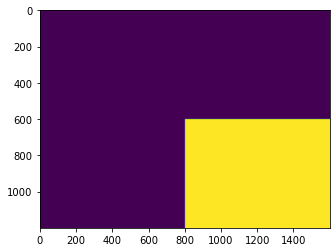

In [7]:
plt.imshow(g)

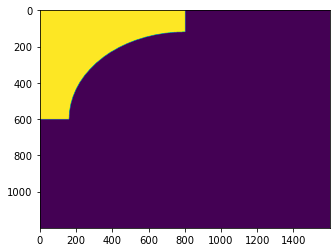

In [101]:
plt.imshow((f ==0).astype(int)*g)

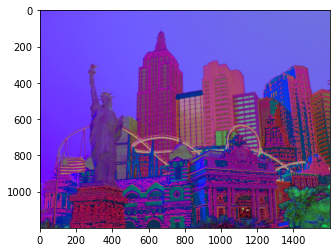

In [67]:
plt.imshow(a.img)

In [72]:
f.m()

1.0

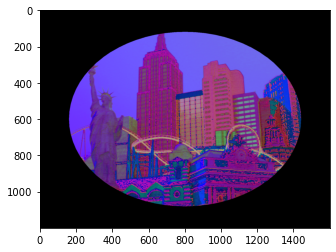

In [75]:
plt.imshow((f*a.img).astype(int))

## Distancias

In [4]:
def euclidiana(x,y):
    return np.sqrt(np.sum(x**2+y**2))

def coseno(x,y): 
    num = np.dot(x,y)
    den = np.sqrt((x**2).sum())*np.sqrt((y**2).sum())
    return num/den

def chi_cuadrado(x,y):
    x_t = x.sum()
    y_t = y.sum()
    c = x + y
    x_esperado = x_t*c/(x_t+y_t)
    y_esperado = y_t*c/(x_t+y_t)
    
    return (((x-x_esperado)**2)/x_esperado).sum() + (((y-y_esperado)**2)/y_esperado).sum()
    
def cramer(x,y):
    return(np.sqrt(chi_cuadrado(x,y)/(x.sum() + y.sum())))

## Content Based Image Retrieval (CBIR)

In [3]:
class CBIR():
    
    def __init__(self, distance):
        self.distance = distance
        self.database = list()
    
    def train(X):
        for image in X:
            self.database.append(Imagen(X).calcularVectorCaracteristicas())
    def evaluar(Input):
        scores = [self.distance(Input, x) for x in self.database]

## Convolutional Neural Network (CNN)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, InputLayer
from keras.utils import np_utils
import pickle

In [10]:
def CBIR_dataset():
    path = os.getcwd() + '\jpg\\'
    imagenes = os.listdir(path) 
    
    X_train,  X_test, y_train, y_test = ([],[],[],[])
    
    for imagen in imagenes:
        ID = int(imagen.split('.')[0])
        clase = (ID // 100) % 1000
        img = cv2.imread(path+imagen)
        img = cv2.resize(img,(128,128)) #reescalamiento
        img = img / 255 #normalización
        
        if (ID % 100) > 0:
            X_train.append(img)
            y_train.append(clase)
        else:
            X_test.append(img)
            y_test.append(clase)
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
        

t = time.time()
X_train, X_test, y_train, y_test = CBIR_dataset()
print('tiempo de procesamiento base de datos: %s segundos'%(time.time()-t))

NameError: name 'pickle' is not defined

In [4]:
#Aleatorizamos las clases de entrenamiento y prueba
np.random.seed(4)
idx = list(np.random.choice(len(y_train), size=len(y_train), replace=False))
idx2 = list(np.random.choice(len(y_test), size=len(y_test), replace=False))

X_train = X_train[idx]
y_train = y_train[idx]

X_test = X_test[idx2]
y_test = y_test[idx2]

print(X_train[0].shape)

(128, 128, 3)


In [ ]:
# conversión de clases a variable categórica
n_classes = 500
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(100, kernel_size=(4,4), strides=(1,1), padding='same', activation='relu', input_shape=(128, 128, 3)))

# convolutional layer
model.add(Conv2D(150, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(2000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(500, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))

Se tienen un accuracy muy bajo debido a la baja de muestras de entrenamiento, por lo que se hará data augmentation para ampliar el dataset. 

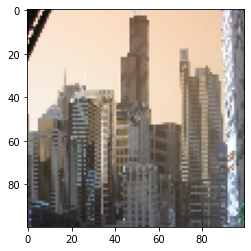

In [49]:
plt.imshow(X_train[2])

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                            zoom_range=0.2, vertical_flip=True)
datagen.fit(X_train)

In [9]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 500
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(128, 128, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(500, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.fit(datagen.flow(X_train, Y_train), steps_per_epoch=X_train.shape[0] // 100, validation_data=(X_test, Y_test), epochs=40)

Shape before one-hot encoding:  (991,)
Shape after one-hot encoding:  (991, 500)
Epoch 1/40
9/9 [==============================] - 32s 4s/step - loss: 7.0059 - accuracy: 0.0035 - val_loss: 6.2146 - val_accuracy: 0.0020
Epoch 2/40
9/9 [==============================] - 31s 3s/step - loss: 6.2137 - accuracy: 0.0035 - val_loss: 6.2143 - val_accuracy: 0.0020
Epoch 3/40
9/9 [==============================] - 31s 3s/step - loss: 6.1978 - accuracy: 0.0070 - val_loss: 6.2203 - val_accuracy: 0.0020
Epoch 4/40
9/9 [==============================] - 31s 3s/step - loss: 6.1866 - accuracy: 0.0104 - val_loss: 6.2201 - val_accuracy: 0.0020
Epoch 5/40
9/9 [==============================] - 32s 4s/step - loss: 6.1729 - accuracy: 0.0069 - val_loss: 6.2168 - val_accuracy: 0.0020
Epoch 6/40
9/9 [==============================] - 31s 3s/step - loss: 6.1668 - accuracy: 0.0035 - val_loss: 6.2374 - val_accuracy: 0.0020
Epoch 7/40
9/9 [==============================] - 31s 3s/step - loss: 6.1159 - accuracy: 0.